In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import norm

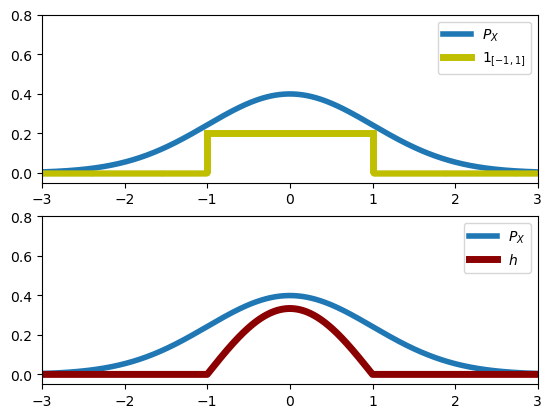

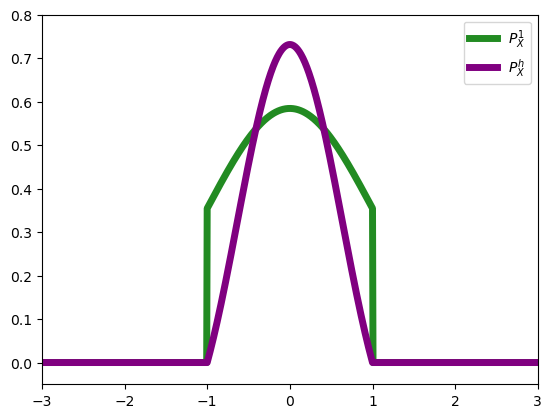

In [3]:
fig = plt.figure()
ax = fig.subplots(nrows=2, ncols=1)

x = np.linspace(-3, 3, 1000)

indic = (x <= 1) & (x >= -1)
ax[0].plot(x, norm.pdf(x), label=f"$P_X$", linewidth=4)
ccdf = norm.cdf(1) - norm.cdf(-1)
ax[0].plot(x[indic], np.ones_like(x[indic]) * 0.2, color='y', linewidth=5, label=f"$1_{{[-1,1]}}$")
ax[0].vlines(-1, ymin=0, ymax=0.2, color='y', linewidth=5)
ax[0].vlines(1, ymin=0, ymax=0.2, color='y', linewidth=5)
ax[0].plot(x[~indic], np.zeros_like(x[~indic]), '.', color='y', linewidth=5)
ax[0].set_xlim(-3,3)
ax[0].set_ylim(-0.05, 0.8)
ax[0].legend()
# ax[0,0].savefig('indic_tilt.pdf')

ax[1].plot(x, norm.pdf(x), label=f"$P_X$", linewidth=4)
tilt = np.maximum(np.cos(np.pi/2*x), np.zeros_like(np.cos(x)))/ 3
ax[1].plot(x, tilt, color='darkred', linewidth=5, label=f"$h$")
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-0.05, 0.8)
ax[1].legend()
fig.savefig('figures/tilts.pdf')


plt.figure()
plt.xlim(-3, 3)
plt.ylim(-0.05, 0.8)
zeros = np.zeros_like(x)
zeros[indic] = 1
plt.plot(x, (norm.pdf(x) * zeros) /ccdf, color='forestgreen', label=f"$P^1_X$", linewidth=5)
plt.plot(x, (norm.pdf(x) * tilt) * 5.5, color='purple', label=f"$P^h_X$", linewidth=5)
plt.legend()
plt.savefig('figures/tilted_dist.pdf')



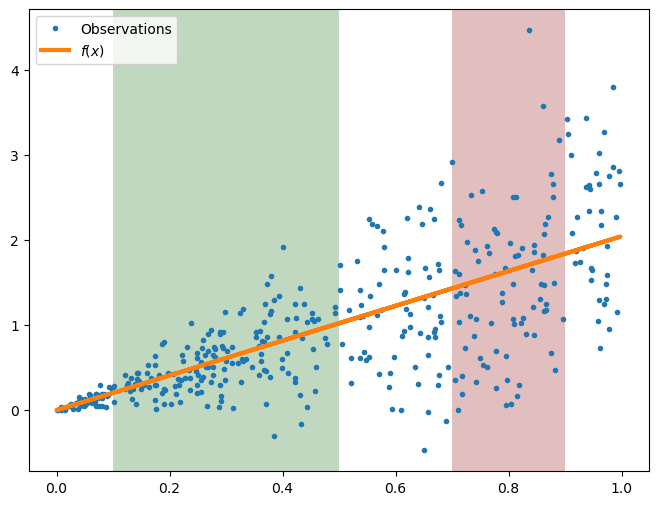

In [4]:
rng = np.random.default_rng(seed=3)

n = 1000
theta_0 = rng.standard_normal()
x = rng.uniform(0, 1, n)
y = rng.normal(theta_0 * x, np.abs(x))

theta_hat, _, _, _ = np.linalg.lstsq(x.reshape(-1,1), y, rcond=None)

s = 400
x = rng.uniform(0, 1, s)
y = rng.normal(theta_0 * x, np.abs(x))
plt.figure(figsize=(8,6))
plt.plot(x, y, '.', label='Observations')
plt.plot(x, x * theta_hat, lw=3, label=f'$f(x)$')
plt.axvspan(0.1, 0.5, facecolor='darkgreen', alpha=0.25)
plt.axvspan(0.7, 0.9, facecolor='darkred', alpha=0.25)
plt.legend()
# plt.savefig('figures/olsh_certificates.pdf')

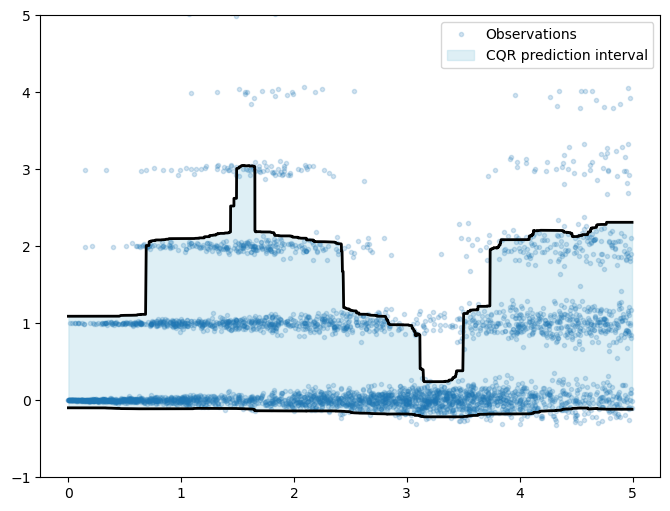

In [5]:
import pandas as pd

audit_trail = pd.read_csv('../data/oos_data.csv', index_col=0)

rng = np.random.default_rng(seed=0)

sample_size = 4000
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx]
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]

plt.figure(figsize=(8,6))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.2, label='Observations')
plt.plot(X, Z1, color='k', lw=2)
plt.plot(X, Z2, color='k', lw=2)
plt.fill_between(X, Z1, Z2, color='lightblue', alpha=0.4, label='CQR prediction interval')
# plt.axvspan(0.8, 1.5, facecolor='darkred', alpha=0.25)
# plt.axvspan(2.3, 3.4, facecolor='darkred', alpha=0.25)
plt.ylim(-1,5)
plt.legend()
# plt.savefig('cqr_interval.pdf')

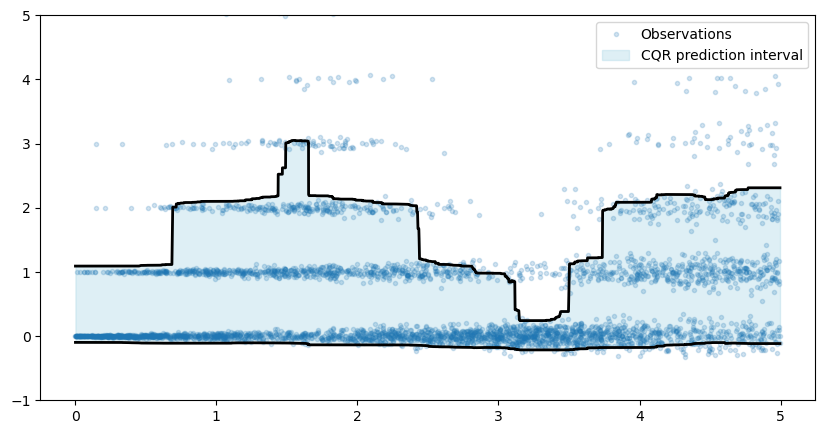

In [6]:
import pandas as pd

plt.rcParams.update({'font.size': 10})

audit_trail = pd.read_csv('../data/oos_data.csv', index_col=0)

rng = np.random.default_rng(seed=0)

sample_size = 4000
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx]
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]

plt.figure(figsize=(10,5))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.2, label='Observations')
plt.plot(X, Z1, color='k', lw=2)
plt.plot(X, Z2, color='k', lw=2)
plt.fill_between(X, Z1, Z2, color='lightblue', alpha=0.4, label='CQR prediction interval')
# plt.axvspan(0.8, 1.5, facecolor='darkred', alpha=0.25)
# plt.axvspan(2.3, 3.4, facecolor='darkred', alpha=0.25)
plt.ylim(-1,5)
plt.legend()
# plt.savefig('cqr_interval.pdf')

In [9]:
from fairaudit import Auditor
from fairaudit.metrics import Metric

auditor = Auditor(
    X=X.reshape(-1,1),
    Y=Y,
    Z=np.concatenate([Z1.reshape(-1,1), Z2.reshape(-1,1)], axis=1),
    metric=Metric('equalized_coverage')
)


from fairaudit.groups import get_rectangles

discretization = np.arange(0, 5, 0.1)
intervals_at = get_rectangles(X.reshape(-1,1), {0:discretization})

auditor.calibrate_groups(
    alpha=0.1,
    type='upper',
    groups=intervals_at,
    bootstrap_params={'seed': 0, 'student': 'prob_bound', 'student_threshold': 0.01**(3/2)}
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 89.58it/s]


0.8594162721576839
0.7869340387858513
0.7599844370549175
0.8392256311084232
0.9161285162230084


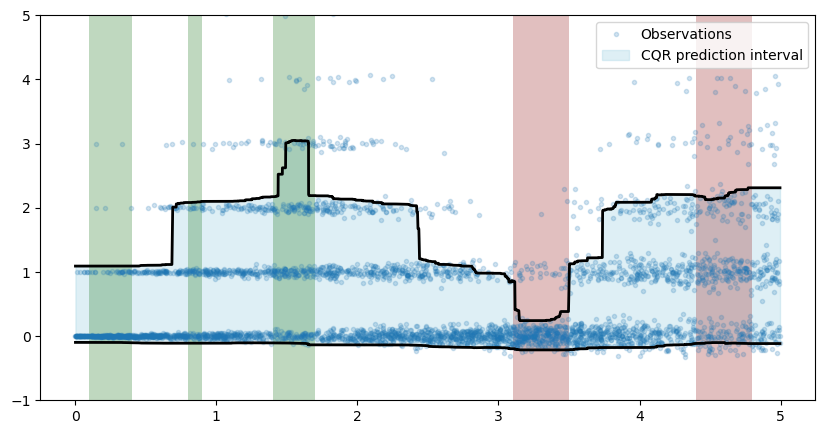

In [10]:
plt.figure(figsize=(10,5))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.2, label='Observations')
plt.plot(X, Z1, color='k', lw=2)
plt.plot(X, Z2, color='k', lw=2)
plt.fill_between(X, Z1, Z2, color='lightblue', alpha=0.4, label='CQR prediction interval')


g_1 = (0.8, 0.9)
g_2 = (3.1, 3.5)
g_3 = (4.4, 4.8)
g_4 = (1.4, 1.7)
g_5 = (0.1, 0.4)
groups = (g_1, g_2, g_3, g_4, g_5)

for g in groups:
    group = (X <= g[1]) & (X >= g[0])

    bound, raw_val, threshold = auditor.query_group(group)
    print(bound[0])
    if bound[0] >= 0.8:
        color = 'darkgreen'
    else:
        color = 'darkred'
    plt.axvspan(g[0], g[1], facecolor=color, alpha=0.25)
    
plt.ylim(-1,5)
plt.legend(loc='upper right')
# plt.savefig("figures/highlighted_cqr_interval.pdf")

In [11]:
from tqdm import tqdm
widths = []
bounds = []
values = []
for ind in tqdm(intervals_at.T):
    x_vals = X[ind]
    width = np.round(x_vals.max() - x_vals.min(), 1)
    bound, value, _ = auditor.query_group(ind)
    widths.append(width)
    bounds.append(bound[0])
    values.append(value[0])
    
pd.DataFrame(dict(width=widths, bound=bounds, value=values))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:08<00:00, 159.21it/s]


,width,bound,value
0,0.1,0.693524,0.808219
1,0.1,0.707222,0.821918
2,0.2,0.733967,0.815068
3,0.1,0.743166,0.848837
4,0.2,0.758762,0.836478
...,...,...,...
1270,4.6,0.893460,0.909583
1271,4.7,0.892210,0.908174
1272,4.8,0.891065,0.906850
1273,4.9,0.889633,0.905271


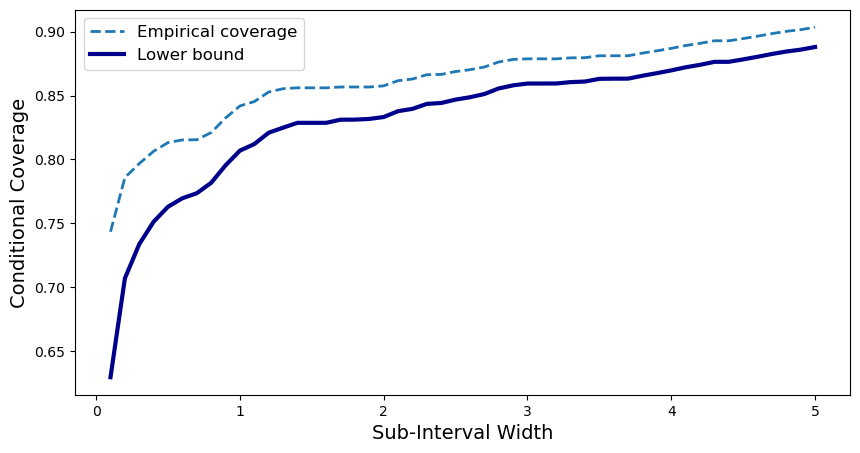

In [12]:
lower_bounds = pd.DataFrame(dict(width=widths, bound=bounds, value=values)).groupby("width").min()
lower_bounds = lower_bounds[lower_bounds['bound'] >= 0.3]
plt.figure(figsize=(10, 5))
plt.plot(lower_bounds.index, lower_bounds['value'][::-1].cummin()[::-1], '--', lw=2, 
         label="Empirical coverage")
plt.plot(lower_bounds.index, lower_bounds['bound'][::-1].cummin()[::-1], lw=3, color='darkblue', 
         label="Lower bound")
plt.xlabel("Sub-Interval Width", size=14)
plt.ylabel("Conditional Coverage", size=14)
plt.legend(fontsize=12)
# plt.savefig("bound_cqr_interval.pdf")

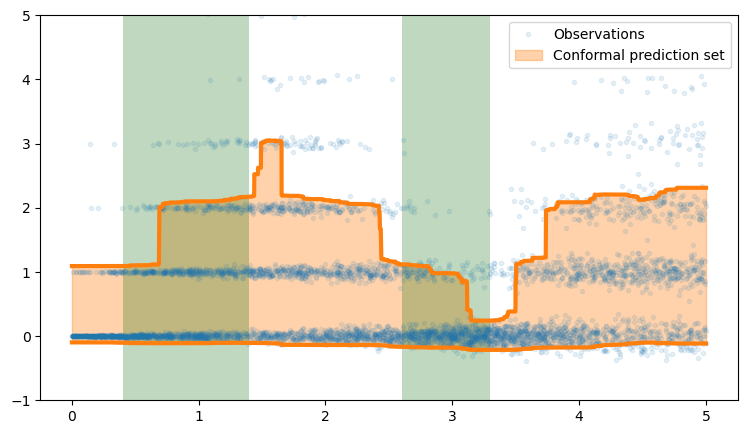

In [14]:
import pandas as pd

audit_trail = pd.read_csv('../data/oos_data.csv', index_col=0)

rng = np.random.default_rng(seed=0)

sample_size = 5000
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx]
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]

plt.figure(figsize=(9,5))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.1, label='Observations')
plt.plot(X, Z1, color='#ff7f0e', lw=3)
plt.plot(X, Z2, color='#ff7f0e', lw=3)
plt.fill_between(X, Z1, Z2, color='#ff7f0e', alpha=0.35, label='Conformal prediction set')
plt.axvspan(0.4, 1.4, facecolor='darkgreen', alpha=0.25)
plt.axvspan(2.6, 3.3, facecolor='darkgreen', alpha=0.25)
plt.ylim(-1,5)
plt.legend()
plt.savefig('figures/cqr_preview.pdf')

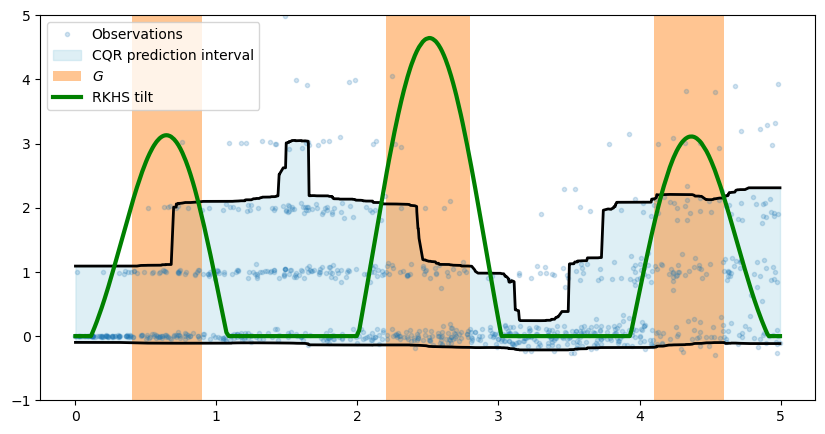

In [26]:
import cvxpy as cp
from sklearn.metrics.pairwise import pairwise_kernels

rng = np.random.default_rng(seed=0)

sample_size = 1000
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)
s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx].reshape(-1,1)
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]

sd = 0.5
K = pairwise_kernels(X, metric='rbf', **{'gamma' : 1/sd**2}) + 1e-6 * np.eye(len(X))

L = np.linalg.cholesky(K)

w = cp.Variable((len(X), 1))
c = cp.Variable()

filters = (X <= 2.8) & (X >= 2.2) 
filters |= (X >= 0.4) & (X <= 0.9) 
filters |= (X >= 4.1) & (X <= 4.6) 

target = 10* (filters).astype(int) - 3


plt.figure(figsize=(10,5))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.2, label='Observations')
plt.plot(X.flatten(), Z1, color='k', lw=2)
plt.plot(X.flatten(), Z2, color='k', lw=2)
plt.fill_between(X.flatten(), Z1, Z2, color='lightblue', alpha=0.4, label='CQR prediction interval')
# plt.plot(X.flatten(), filters.astype(int) * 3, '.')
plt.axvspan(0.4, 0.9, facecolor='#ff7f0e', alpha=0.45, label=f'$G$')
plt.axvspan(2.2, 2.8, facecolor='#ff7f0e', alpha=0.45)
plt.axvspan(4.1, 4.6, facecolor='#ff7f0e', alpha=0.45)

plt.ylim(-1, 5)

lmbda = 1
obj = cp.Minimize(cp.sum_squares(L @ w - target) - lmbda * c)
constraints = [cp.norm(w) <= 1, cp.sum(L @ w) >= c]
prob = cp.Problem(obj, constraints)
prob.solve(solver='MOSEK')

real_w = np.linalg.solve(L.T, w.value/np.linalg.norm(w.value))

plt.plot(X.flatten(), 8 * (K @ real_w).clip(0), color='green', lw=3, label='RKHS tilt')
plt.legend()
# plt.savefig('figures/interval_union_rkhs_fit.pdf')

In [22]:
auditor = Auditor(
    X=X,
    Y=Y,
    Z=np.concatenate((Z1.reshape(-1,1), Z2.reshape(-1,1)), axis=1),
    metric=Metric('equalized_coverage')
)


In [23]:
discretization = np.arange(0, 5, 0.1)
intervals_at = get_rectangles(X, {0:discretization})

auditor.calibrate_groups(
    alpha=0.1,
    type='upper',
    groups=intervals_at,
    bootstrap_params={'seed': 0, 'student': 'prob_bound', 'student_threshold': 0.1**(3/2)}
)

filters1 = (X <= 2.6) & (X >= 2.2) 
filters2 = (X >= 0.5) & (X <= 0.8) 
filters3 = (X >= 4.2) & (X <= 4.6) 
filters4 = (X >= 3.3) & (X <= 3.6) 


print(auditor.query_group(filters1))
print(auditor.query_group(filters2))
print(auditor.query_group(filters3))
print(auditor.query_group(filters4))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 303.47it/s]


([0.7823497017908339], [0.9333333333333333], [0])
([0.706655850988521], [0.9206349206349206], [0])
([0.6351505108976243], [0.7945205479452054], [0])
([0.6042253880641547], [0.782608695652174], [0])


In [24]:
auditor.calibrate_rkhs(
    alpha=0.1,
    type='upper',
    kernel='rbf',
    kernel_params={'gamma': 1/sd**2},
    bootstrap_params={'seed': 0}
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 91.12it/s]


In [28]:
auditor.query_rkhs(real_w)

([0.75980063120083], [0.9079999999999996])

In [29]:
dataset = pd.read_csv('../data/compas_bounds.csv', index_col=0)

aa_dataset = dataset[dataset['races'] == "African-American"]#.sort_values(by='races')
all_dataset = dataset[dataset['races'] == "all"]
all_dataset

,races,ages,sexes,lowers,uppers
2,all,25 - 45,all,-0.008981,0.087891
3,all,Greater than 45,all,-0.111837,0.117690
4,all,Less than 25,all,-0.025991,0.105682
5,all,all,Female,-0.165846,0.011758
6,all,all,Male,0.018626,0.099865
18,all,25 - 45,Female,-0.146694,0.087823
19,all,25 - 45,Male,0.000651,0.107021
20,all,Greater than 45,Female,-0.414181,0.231630
21,all,Greater than 45,Male,-0.105815,0.139744
22,all,Less than 25,Female,-0.299988,-0.000142


Text(0.5, 0, 'Positive Predictive Value Disparity')

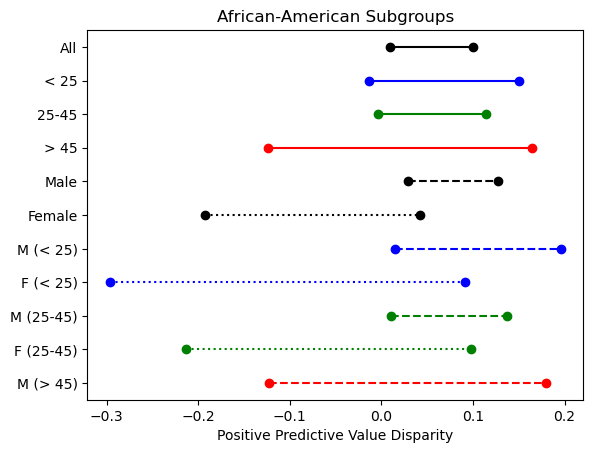

In [30]:
aa_indices = [0, 9, 7, 8, 14, 13, 29, 28, 25, 24, 27]
all_indices = [4, 2, 3, 6, 5, 23, 22, 19, 18, 21, 20]
def get_color(age):
    if age == "Less than 25":
        return 'blue'
    elif age == "25 - 45":
        return 'g'
    elif age == "Greater than 45":
        return 'r'
    return 'black'

def get_linestyle(sex):
    if sex == "Male":
        return "dashed"
    elif sex == "Female":
        return "dotted"
    return "solid"

def simplify(x):
    if x == "Male":
        return "M"
    if x == "Female":
        return "F"
    if x == "Less than 25":
        return "< 25"
    if x == "25 - 45":
        return "25-45"
    if x == "Greater than 45":
        return "> 45"

labels = []
for y, idx in enumerate(aa_indices[::-1]):
    row = aa_dataset.loc[idx]
    lower = row[3]
    upper = row[4]
    color = get_color(row[1])
    linestyle = get_linestyle(row[2])
    if row[1] == 'all':
        if row[2] == 'all':
            labels.append('All')
        else:
            labels.append(f'{row[2]}')
    elif row[2] == 'all':
        labels.append(f'{simplify(row[1])}')
    else:
        labels.append(f'{simplify(row[2])} ({simplify(row[1])})')
    plt.plot((lower,upper),(y,y),'o',color=color, linestyle=linestyle)

plt.yticks(range(len(all_indices)),labels)
plt.title("African-American Subgroups")
plt.xlabel("Positive Predictive Value Disparity")
# plt.savefig('figures/ppv_intervals_afam.pdf')

In [579]:
import pickle

with open('ground_truth.pkl', 'wb') as fp:
    pickle.dump(coverages_gt, fp)

In [572]:
def run_trial(audit_trail, seed):
#     intervals_at = get_rectangles(audit_trail['x'].to_numpy().reshape(-1,1), {0:np.arange(0, 5, 1)})
    
#     auditor = Auditor(
#         X=audit_trail['x'].to_numpy().reshape(-1,1),
#         Y=audit_trail['y'].to_numpy(),
#         Z=audit_trail[['z1', 'z2']].to_numpy(),
#         metric=Metric('equalized_coverage')
#     )

    x = np.random.uniform(0, 5, size=500).reshape(-1,1)
    intervals_at = get_rectangles(x, {0:np.arange(0, 5, 1)})
    
    y = np.random.standard_normal(size=len(x))
    z1 = -1 * np.ones_like(y).reshape(-1,1)
    z2 = 1 * np.ones_like(y).reshape(-1,1)
    z = np.concatenate((z1, z2), axis=1)
    auditor = Auditor(
        X=x,
        Y=y,
        Z=z,
        metric=Metric('equalized_coverage')
    )
    
    auditor.calibrate_groups(
        alpha=0.05,
        type='upper',
        groups=intervals_at,
        bootstrap_params={'seed': seed, 'B': 500, 'method': 'gaussian'}
    )
    coverages = np.ones((len(intervals_at.T),))
    gaps = np.zeros((len(intervals_at.T),))
    for i, interval_dummies in enumerate(intervals_at.T):
        coverage_bound = auditor.query_group(interval_dummies)[0][0]
        min_val = auditor.X[interval_dummies].round(1).min()
        max_val = auditor.X[interval_dummies].round(1).max()
        if max_val == min_val:
            max_val = round(max_val + 0.1, 1)
        cover = coverage_bound <= 1 - 2 * scipy.stats.norm.cdf(-1) # coverages_gt[(min_val, max_val)]
        coverages[i] = cover
        gaps[i] = coverage_bound - (1 - 2 * scipy.stats.norm.cdf(-1))
    
#     print('realized coverage gap minimizer', intervals_at[:,gaps.argmax()].mean())

    fwer = np.all(coverages)
    return fwer

In [577]:
fwers = []
audit_trail = audit_trail.sample(frac=1).reset_index(drop=True)
for i in np.arange(0, 10 * len(audit_trail), step=500):
    fwer = run_trial(audit_trail[i:(i + 500)], seed=int(i/500))
    fwers.append(fwer)
    if int(i / 500) % 10 == 0:
        print(int(i/500), np.mean(fwers))

0 1.0
10 1.0
20 1.0
30 1.0
40 0.975609756097561
50 0.9607843137254902
60 0.9508196721311475
70 0.9577464788732394
80 0.9629629629629629
90 0.9560439560439561
100 0.9504950495049505
110 0.9459459459459459
120 0.9421487603305785
130 0.9389312977099237
140 0.9361702127659575
150 0.9337748344370861
160 0.9316770186335404
170 0.9298245614035088
180 0.9337016574585635
190 0.9319371727748691
200 0.9303482587064676
210 0.9289099526066351
220 0.9276018099547512
230 0.9264069264069265
240 0.9253112033195021
250 0.9282868525896414
260 0.9310344827586207
270 0.933579335793358
280 0.9323843416370107
290 0.9312714776632303
300 0.9335548172757475
310 0.9356913183279743
320 0.9376947040498442
330 0.9395770392749244
340 0.9413489736070382
350 0.9430199430199431
360 0.9445983379501385
370 0.9460916442048517
380 0.9448818897637795
390 0.9462915601023018
400 0.942643391521197
410 0.9416058394160584
420 0.9429928741092637
430 0.9443155452436195
440 0.9455782312925171
450 0.9445676274944568
460 0.9457700650

In [377]:
# comparison to alternative method

def sample_ci_score(x, coverage, rng, boot_index, method='multinomial'):
    sort_idx = np.argsort(x.flatten())
    x = x[sort_idx].flatten()
    L = ~coverage[sort_idx]
    
    n = len(x)
    if method == 'multinomial':
        w = rng.multinomial(n, [1/n] * n, size=1).flatten()
    elif method == 'gaussian':
        w = rng.standard_normal(size=n)
    
    g = np.ones_like(x) / n
    wg = w / n
    wL = (w * L) / n
    L = L / n
    
    num_chunks = int(5 / 0.1)
    chunk_vals = np.zeros((num_chunks, 4))
    
    
    for i, start in enumerate(np.linspace(0, 4.9, num_chunks)):
        idx = np.where((x >= start) & (x <= start + 0.1))
        chunk_vals[i,0] = np.sum(g[idx]) 
        chunk_vals[i,1] = np.sum(wL[idx])
        chunk_vals[i,2] = np.sum(L[idx])
        chunk_vals[i,3] = np.sum(wg[idx])
    
    num_scores = int((num_chunks * (num_chunks + 1))/2)
    score_df = np.empty((num_scores,7))
    score_df[:,3] = np.arange(num_scores)
    score_df[:,4] = boot_index
    
    idx = 0
    
    for i, start in enumerate(np.linspace(0, 4.9, num_chunks)):
        i_sums = np.cumsum(chunk_vals[i:num_chunks,], axis=0)
        scores = i_sums[:,0] * i_sums[:,1] - i_sums[:,2] * i_sums[:,3]
        
        score_df[idx:idx + len(i_sums),0] = scores
        score_df[idx:idx + len(i_sums),1] = start
        score_df[idx:idx + len(i_sums),2] = np.linspace(start + 0.1, 5, len(i_sums))
        score_df[idx:idx + len(i_sums),5] = 1 - i_sums[:,2] / i_sums[:,0]
        score_df[idx:idx + len(i_sums),6] = i_sums[:,0]
        idx += len(i_sums)   
        
    return score_df

def compute_bound(score_df, idx, method, trim_prob):
    score_df[f's_g_{idx}'] = compute_student(score_df, method, trim_prob)
    score_df['score_scaled'] = score_df['score'] / score_df[f's_g_{idx}']
    t_s = score_df.groupby('boot')['score_scaled'].min().quantile(0.05)
    score_df[f'bound_{idx}'] = score_df['empirical'] + (t_s * score_df[f's_g_{idx}']) / score_df['P_G']**2
    score_df[f'bound_{idx}'] = score_df[f'bound_{idx}']
    return score_df

def compute_student(score_df, method, trim_prob):
    if method == "prob":
        students = score_df["P_G"]**(3/2)
        students[score_df['P_G'] <= trim_prob] = (trim_prob)**(3/2)
    elif method == "mad":
        students = score_df.groupby("interval")['score'].transform(scipy.stats.median_abs_deviation)
    elif method == "iqr":
        students = score_df.groupby("interval")['score'].transform(scipy.stats.iqr)
    elif method == "estimator":
        P_LG = (1 - score_df['empirical']) * score_df['P_G']
        students = np.sqrt(P_LG * score_df['P_G'] * (score_df['P_G'] - P_LG))
        students = students.clip(students.quantile(0.3))
    elif method == 'width':
        students = ((score_df['end'] - score_df['start']) / 5)**(3/2)
        students[score_df['P_G'] <= trim_prob] = 1
    else:
        students = np.ones((len(score_df,)))
    students[students == 0] += 1
    return students

def run_old_trial(seed, audit_trail, methods, trim_probs):
    np.random.seed(seed)
    rng = np.random.default_rng(seed=seed)

    x_test = audit_trail['x'].to_numpy().reshape(-1,1)

#     # generate labels
    y_test = audit_trail['y'].to_numpy()

    # reshape the features
    x_test = np.reshape(x_test,(-1,1))
    
    y_lower = audit_trail['z1'].to_numpy()
    y_upper = audit_trail['z2'].to_numpy()


    coverage = (y_test >= y_lower) & (y_test <= y_upper)

    num_chunks = int(5 / 0.1)
    num_scores = int((num_chunks * (num_chunks + 1))/2)

    B = 1000
    score_df = np.zeros((B * num_scores, 7))
    idx = 0
    for b in range(B):
        score_df[idx:(idx + num_scores),] = sample_ci_score(x_test, coverage, rng, b, method='gaussian')
        idx += num_scores

    score_df = pd.DataFrame(score_df, columns=['score', 'start', 'end', 'interval', 'boot', 'empirical', 'P_G'])
    score_df['length'] = score_df['end'] - score_df['start']

    bound_idx = 0
    for method in methods:
        for trim in trim_probs:
            score_df = compute_bound(score_df, bound_idx, method, trim)
            bound_idx += 1
            
    comp_df = score_df.merge(oos_df, on=['interval'])
    fwer = np.empty((len(methods) * len(trim_probs),))
    for j in range(bound_idx):
#         fwer[j] = (comp_df[f'bound_{j}'] <= 0.5).all()
        fwer[j] = (comp_df[f'bound_{j}'] < comp_df['coverage']).all()
            
    return fwer, comp_df

In [114]:
x_oos = ground_truth['x'].to_numpy()
sort_idx = np.argsort(x_oos.flatten())
x_oos = x_oos[sort_idx]

coverage_oos = ((ground_truth['y'] <= ground_truth['z2']) & (ground_truth['y'] >= ground_truth['z1'])).to_numpy()
coverage_oos = coverage_oos[sort_idx]

num_chunks = int(5 / 0.1)

chunk_vals = np.zeros((num_chunks, 2))
g = np.ones_like(coverage_oos)

for i, start in enumerate(np.linspace(0, 4.9, num_chunks)):
    idx = np.where((x_oos >= start) & (x_oos <= start + 0.1))
    chunk_vals[i,0] = np.sum(g[idx]) 
    chunk_vals[i,1] = np.sum(coverage_oos[idx])
    
num_sets = int((num_chunks * (num_chunks + 1))/2)
oos_df = np.empty((num_sets,2))

oos_df[:,1] = np.arange(num_sets)

idx = 0

for i, start in enumerate(np.linspace(0, 4.9, num_chunks)):
    i_sums = np.cumsum(chunk_vals[i:num_chunks,], axis=0)
    group_cov = i_sums[:,1] / i_sums[:,0]

    oos_df[idx:idx + len(i_sums),0] = group_cov
    idx += len(i_sums)
    
oos_df = pd.DataFrame(oos_df, columns=['coverage', 'interval'])

In [380]:
from tqdm import tqdm

methods = ['none'] # ['prob', 'width']# ['prob', 'iqr', 'none']
trim_probs = [1]
# trim_probs = [25 / n_test, .5, 1]#[0, 25 / n_test, 0.05]

n_trials = int(len(audit_trail) / 500)
fwer_array = np.empty((n_trials, len(methods) * len(trim_probs)),)
prob_widths = np.asarray([])
for idx in tqdm(np.arange(0, len(audit_trail), step=500)):
    fwer, score_df = run_old_trial(idx, audit_trail[idx:(idx + 500)], methods, trim_probs)
    fwer_array[int(idx/500),] = fwer
    break
    if int(idx/500) % 10 == 0:
        print(np.mean(fwer_array[0:(int(idx/500)+1),:], axis=0))

  0%|                                                                                                                                                                                                                                                                                         | 0/200 [00:03<?, ?it/s]

0          -73.139598
1000       -14.013269
2000        -5.672564
3000        -2.778317
4000        -1.859786
              ...    
1270000    -22.708232
1271000     -5.145808
1272000   -121.843008
1273000    -10.656536
1274000    -22.770732
Name: bound_0, Length: 1275, dtype: float64


In [701]:
from tqdm import tqdm
rng = np.random.default_rng(seed=3)

n = 800
alpha=0.1
def dumb_trial(alpha):
    bias = 0.5
    dataset = rng.choice([0,1], p=[1 - bias, bias], size=(n,))

    stats = []
    for b in range(500):
        w = rng.multinomial(n, [1/n] * n, size=1).reshape(-1)

        stats.append(np.mean(w * dataset - dataset))
    
    return (np.mean(dataset) - np.quantile(stats, 1-alpha)) <= bias

bools = []
for _ in tqdm(range(1000)):
    bools.append(dumb_trial(alpha))
    
np.mean(bools)

0.91